In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import pickle

In [2]:
data = pd.read_csv('lending_club_loan_two.csv')


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [4]:
data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [5]:
def get_missing_data_info(dataframe):
    total = dataframe.isnull().sum().sort_values(ascending=False)
    percent_1 = dataframe.isnull().sum() / dataframe.isnull().count()*100
    percent_2 = (round(percent_1,1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    missing_data = missing_data[missing_data['Total'] > 0]
    return missing_data

In [6]:
get_missing_data_info(data)

,Total,%
mort_acc,37795,9.5
emp_title,22927,5.8
emp_length,18301,4.6
title,1755,0.4
pub_rec_bankruptcies,535,0.1
revol_util,276,0.1


In [7]:
data.corr()['mort_acc'].sort_values(ascending=False)

mort_acc                1.000000
total_acc               0.381072
annual_inc              0.236320
loan_amnt               0.222315
revol_bal               0.194925
installment             0.193694
open_acc                0.109205
pub_rec_bankruptcies    0.027239
pub_rec                 0.011552
revol_util              0.007514
dti                    -0.025439
int_rate               -0.082583
Name: mort_acc, dtype: float64

In [8]:
len(data['mort_acc'].unique())

34

<AxesSubplot:>

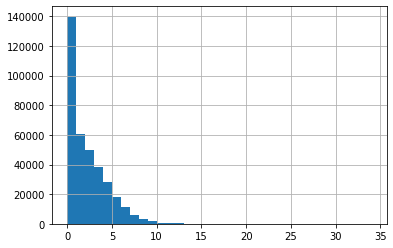

In [9]:
data['mort_acc'].hist(bins=34)

In [10]:
data['mort_acc'].value_counts().sort_index()

0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
21.0         4
22.0         7
23.0         2
24.0        10
25.0         4
26.0         2
27.0         3
28.0         1
30.0         1
31.0         2
32.0         2
34.0         1
Name: mort_acc, dtype: int64

In [11]:
data['mort_acc'].describe()

count    358235.000000
mean          1.813991
std           2.147930
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          34.000000
Name: mort_acc, dtype: float64

In [12]:
data['mort_acc'].mode()

0    0.0
dtype: float64

In [13]:
data['mort_acc'].dtype

dtype('float64')

In [14]:
data.loc[data['mort_acc'] == 0, 'mort_acc_amnt'] = '0'
data.loc[(data['mort_acc'] > 0) & (data['mort_acc'] <= 6), 'mort_acc_amnt'] = '1-6'
data.loc[(data['mort_acc'] > 6) & (data['mort_acc'] <= 14), 'mort_acc_amnt'] = '7-14'
data.loc[data['mort_acc'] > 15, 'mort_acc_amnt'] = 'more-15'
data['mort_acc_amnt'].fillna('unknown', inplace=True)

In [15]:
data.drop('mort_acc', axis=1, inplace=True)

In [16]:
get_missing_data_info(data)

,Total,%
emp_title,22927,5.8
emp_length,18301,4.6
title,1755,0.4
pub_rec_bankruptcies,535,0.1
revol_util,276,0.1


In [17]:
data['emp_title'].nunique()

173105

In [18]:
data['emp_title'].value_counts()

Teacher                    4389
Manager                    4250
Registered Nurse           1856
RN                         1846
Supervisor                 1830
                           ... 
Postman                       1
McCarthy & Holthus, LLC       1
jp flooring                   1
Histology Technologist        1
Gracon Services, Inc          1
Name: emp_title, Length: 173105, dtype: int64

In [19]:
data.drop('emp_title', axis=1, inplace=True)

In [20]:
data['emp_length'].value_counts()

10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
9 years       15314
Name: emp_length, dtype: int64

<AxesSubplot:>

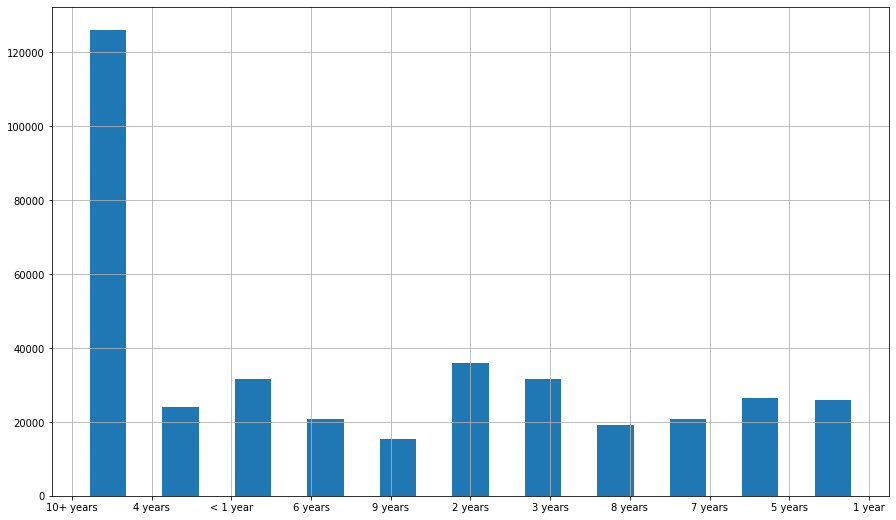

In [21]:
data['emp_length'].hist(bins=11, rwidth=0.5, figsize=(15,9))

[Text(0, 0, '< 1 year'),
 Text(1, 0, '1 year'),
 Text(2, 0, '2 years'),
 Text(3, 0, '3 years'),
 Text(4, 0, '4 years'),
 Text(5, 0, '5 years'),
 Text(6, 0, '6 years'),
 Text(7, 0, '7 years'),
 Text(8, 0, '8 years'),
 Text(9, 0, '9 years'),
 Text(10, 0, '10+ years')]

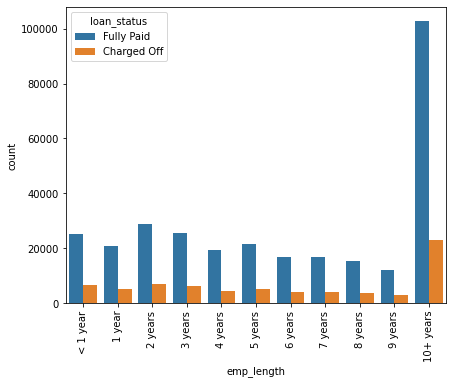

In [22]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g = sns.countplot(x='emp_length', data=data, hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90)


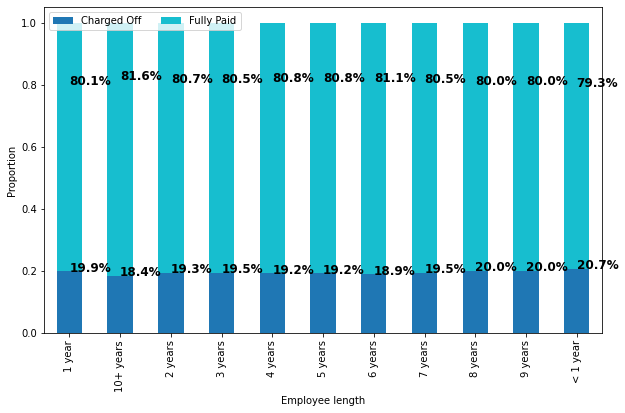

In [23]:
stack_df_props = pd.crosstab(index=data['emp_length'],
                    columns=data['loan_status'],
                    normalize="index")
stack_df = pd.crosstab(index=data['emp_length'],
                    columns=data['loan_status'])

stack_df_props.plot(kind='bar', 
            stacked=True, 
            colormap='tab10', 
            figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Employee length")
plt.ylabel("Proportion")
for n, x in enumerate([*stack_df.index.values]):
    for proportion in stack_df_props.loc[x]:
                
        plt.text(x=n,
                 y=proportion,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.show()

Cung co ti le giong nhau nen co kha nang thuoc tinh quyet dinh khong phu thuoc vao so nam lam viec

In [24]:
data.drop('emp_length', axis=1, inplace=True)

In [25]:
get_missing_data_info(data)

,Total,%
title,1755,0.4
pub_rec_bankruptcies,535,0.1
revol_util,276,0.1


In [26]:
data.select_dtypes('object').head(5)

,term,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,purpose,title,earliest_cr_line,initial_list_status,application_type,address,mort_acc_amnt
0,36 months,B,B4,RENT,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,Jun-1990,w,INDIVIDUAL,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",0
1,36 months,B,B5,MORTGAGE,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,Jul-2004,f,INDIVIDUAL,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",1-6
2,36 months,B,B3,RENT,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,Aug-2007,f,INDIVIDUAL,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113",0
3,36 months,A,A2,RENT,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,Sep-2006,f,INDIVIDUAL,"823 Reid Ford\r\nDelacruzside, MA 00813",0
4,60 months,C,C5,MORTGAGE,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,Mar-1999,f,INDIVIDUAL,"679 Luna Roads\r\nGreggshire, VA 11650",1-6


In [27]:
data['title'].nunique()

48817

In [28]:
data['purpose'].nunique()

14

In [29]:
data.drop('title', axis=1, inplace=True)

In [30]:
get_missing_data_info(data)

,Total,%
pub_rec_bankruptcies,535,0.1
revol_util,276,0.1


In [31]:
data.dropna(inplace=True)

In [32]:
data.shape

(395219, 24)

In [33]:
def is_grade_fit_all_sub_grade(grade):
    for row in data.loc[data['grade'] == grade, ['grade', 'sub_grade']].iterrows():
        current_row = row[1]
        if grade not in (current_row['sub_grade']):
            return False
    return True

In [34]:
for grade in data['grade'].unique():
    if (is_grade_fit_all_sub_grade(grade)):
        print(f'Grade {grade} fits all its sub_grade')
    else:
        print(f'Grade {grade} does not fit all its sub_grade')

Grade B fits all its sub_grade
Grade A fits all its sub_grade
Grade C fits all its sub_grade
Grade E fits all its sub_grade
Grade D fits all its sub_grade
Grade F fits all its sub_grade
Grade G fits all its sub_grade


In [35]:
data.drop('grade', axis=1, inplace=True)

In [36]:
for col in data.select_dtypes('object').columns:
    print(f'Column {col} has {data[col].nunique()} unique values')

Column term has 2 unique values
Column sub_grade has 35 unique values
Column home_ownership has 6 unique values
Column verification_status has 3 unique values
Column issue_d has 112 unique values
Column loan_status has 2 unique values
Column purpose has 14 unique values
Column earliest_cr_line has 684 unique values
Column initial_list_status has 2 unique values
Column application_type has 3 unique values
Column address has 392898 unique values
Column mort_acc_amnt has 5 unique values


In [37]:
data.loc[:, ['issue_d', 'earliest_cr_line']]

,issue_d,earliest_cr_line
0,Jan-2015,Jun-1990
1,Jan-2015,Jul-2004
2,Jan-2015,Aug-2007
3,Nov-2014,Sep-2006
4,Apr-2013,Mar-1999
...,...,...
396025,Oct-2015,Nov-2004
396026,Feb-2015,Feb-2006
396027,Oct-2013,Mar-1997
396028,Aug-2012,Nov-1990


In [38]:
data.drop('earliest_cr_line', axis=1, inplace=True)
data.drop('issue_d', axis=1, inplace=True)

In [39]:
data['address'].value_counts()

USCGC Smith\r\nFPO AE 70466                            8
USS Smith\r\nFPO AP 70466                              8
USS Johnson\r\nFPO AE 48052                            8
USNS Johnson\r\nFPO AE 05113                           8
USNS Johnson\r\nFPO AP 48052                           7
                                                      ..
43570 Maxwell Field Apt. 502\r\nEast John, NH 22690    1
9983 Turner Cove\r\nSouth Gregmouth, WV 70466          1
1312 Cody Shoal\r\nRalphfurt, CO 29597                 1
3841 Liu Crest\r\nClarkchester, NC 29597               1
787 Michelle Causeway\r\nBriannaton, AR 48052          1
Name: address, Length: 392898, dtype: int64

In [40]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [41]:
data.drop('address', axis=1, inplace=True)

In [42]:
data.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [43]:
data['loan_status'] = data.loan_status.map({'Fully Paid':0, 'Charged Off':1})

In [44]:
data.head(5).T

,0,1,2,3,4
loan_amnt,10000.0,8000.0,15600.0,7200.0,24375.0
term,36 months,36 months,36 months,36 months,60 months
int_rate,11.44,11.99,10.49,6.49,17.27
installment,329.48,265.68,506.97,220.65,609.33
sub_grade,B4,B5,B3,A2,C5
home_ownership,RENT,MORTGAGE,RENT,RENT,MORTGAGE
annual_inc,117000.0,65000.0,43057.0,54000.0,55000.0
verification_status,Not Verified,Not Verified,Source Verified,Not Verified,Verified
loan_status,0,0,0,0,1
purpose,vacation,debt_consolidation,credit_card,credit_card,credit_card


In [45]:
dummies = data.select_dtypes('object').columns
data = pd.get_dummies(data, columns=dummies, drop_first=True)

In [46]:
data.head(5).T

,0,1,2,3,4
loan_amnt,10000.00,8000.00,15600.00,7200.00,24375.00
int_rate,11.44,11.99,10.49,6.49,17.27
installment,329.48,265.68,506.97,220.65,609.33
annual_inc,117000.00,65000.00,43057.00,54000.00,55000.00
loan_status,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...
zip_code_30723,0.00,0.00,0.00,0.00,0.00
zip_code_48052,0.00,0.00,0.00,0.00,0.00
zip_code_70466,0.00,0.00,0.00,0.00,0.00
zip_code_86630,0.00,0.00,0.00,0.00,0.00


In [47]:
data['loan_status'].value_counts()/len(data)

0    0.803848
1    0.196152
Name: loan_status, dtype: float64

In [48]:
# data.drop('issue_d', axis=1, inplace=True)


In [49]:
train, test = train_test_split(data, test_size=0.3, random_state=42)
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

In [50]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
# different resampling set for training
random_over = RandomOverSampler()
rd_over_x_train, rd_over_y_train = random_over.fit_resample(X_train,y_train)

random_under = RandomUnderSampler()
rd_under_x_train, rd_y_train = random_under.fit_resample(X_train, y_train)

smote = SMOTE()
sm_x_train, sm_y_train = smote.fit_resample(X_train, y_train)

nm = NearMiss()
nm_x_train, nm_y_train = nm.fit_resample(X_train, y_train)

In [53]:
train_data = {
    "Default": [X_train, y_train],
    "Random Over Sampling": [rd_over_x_train, rd_over_y_train],
    "Random Under Sampling": [rd_under_x_train, rd_y_train],
    "SMOTE": [sm_x_train, sm_y_train],
    "Near Miss": [nm_x_train, nm_y_train]
}

In [51]:
def print_score(true, pred, train=True):
    title = 'Prediction for train data' if train else 'Prediction for test data'
    clf_report = classification_report(true, pred)
    print(f"{title}:\n================================================")
    print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("_______________________________________________")
    cm = confusion_matrix(true, pred)
    print(f"Confusion Matrix: \n {cm}\n")
    plt.figure(figsize=(12,12))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='binary')
    plt.xlabel("Predict values")
    plt.ylabel("Actual values")
    plt.title("Confusion Matrix ")
    plt.show()

In [54]:
def fit_model_and_evaluate(model, title, x_train, y_train, x_test=X_test, y_test=y_test):
    model.fit(x_train, y_train)
    print(title + "\n============================================")
    # y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # print_score(y_train, y_train_pred, train=True)
    print_score(y_test, y_test_pred, train=False)


***************************************************************************************************
Decision Tree with Default data
Prediction for test data:
Accuracy Score: 83.11%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     95356
           1       0.57      0.59      0.58     23210

    accuracy                           0.83    118566
   macro avg       0.73      0.74      0.74    118566
weighted avg       0.83      0.83      0.83    118566

_______________________________________________
Confusion Matrix: 
 [[84791 10565]
 [ 9461 13749]]



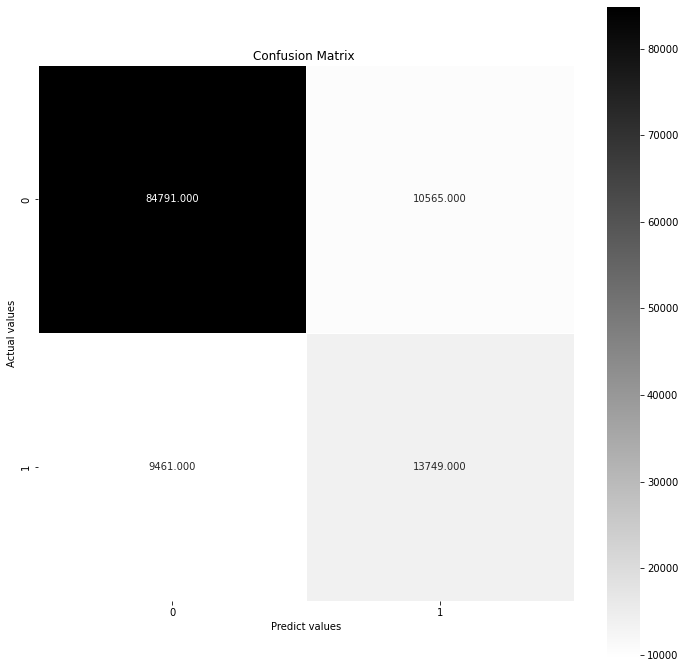


***************************************************************************************************
Naive Bayes with Default data
Prediction for test data:
Accuracy Score: 86.55%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     95356
           1       0.69      0.56      0.62     23210

    accuracy                           0.87    118566
   macro avg       0.80      0.75      0.77    118566
weighted avg       0.86      0.87      0.86    118566

_______________________________________________
Confusion Matrix: 
 [[89576  5780]
 [10165 13045]]



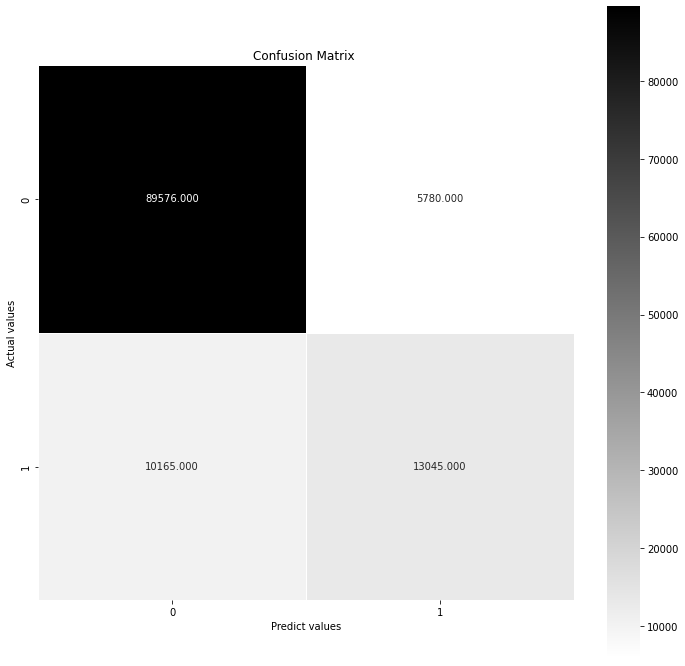


***************************************************************************************************
XGBoost with Default data
Prediction for test data:
Accuracy Score: 88.92%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93     95356
           1       0.92      0.48      0.63     23210

    accuracy                           0.89    118566
   macro avg       0.90      0.73      0.78    118566
weighted avg       0.89      0.89      0.87    118566

_______________________________________________
Confusion Matrix: 
 [[94338  1018]
 [12121 11089]]



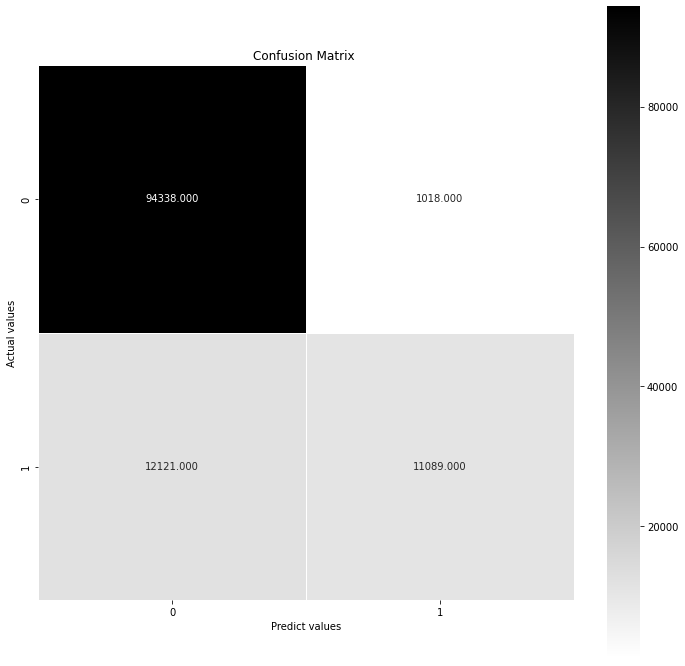


***************************************************************************************************
Random Forest with Default data
Prediction for test data:
Accuracy Score: 88.87%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     95356
           1       0.95      0.45      0.61     23210

    accuracy                           0.89    118566
   macro avg       0.92      0.72      0.77    118566
weighted avg       0.90      0.89      0.87    118566

_______________________________________________
Confusion Matrix: 
 [[94850   506]
 [12692 10518]]



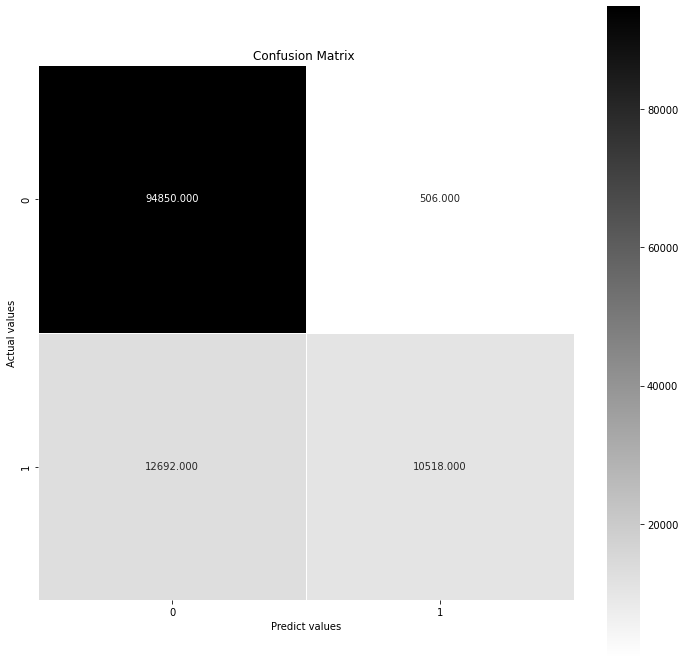


***************************************************************************************************
K Nearest Neighbor with Default data
Prediction for test data:
Accuracy Score: 86.05%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     95356
           1       0.73      0.45      0.56     23210

    accuracy                           0.86    118566
   macro avg       0.80      0.71      0.74    118566
weighted avg       0.85      0.86      0.85    118566

_______________________________________________
Confusion Matrix: 
 [[91477  3879]
 [12658 10552]]



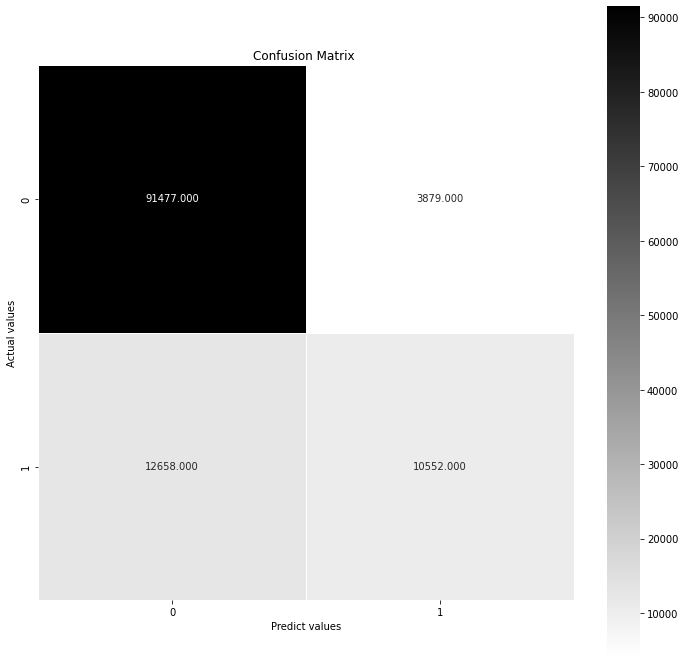


***************************************************************************************************
Gradient Boosting with Default data
Prediction for test data:
Accuracy Score: 88.87%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     95356
           1       0.99      0.44      0.60     23210

    accuracy                           0.89    118566
   macro avg       0.93      0.72      0.77    118566
weighted avg       0.90      0.89      0.87    118566

_______________________________________________
Confusion Matrix: 
 [[95262    94]
 [13108 10102]]



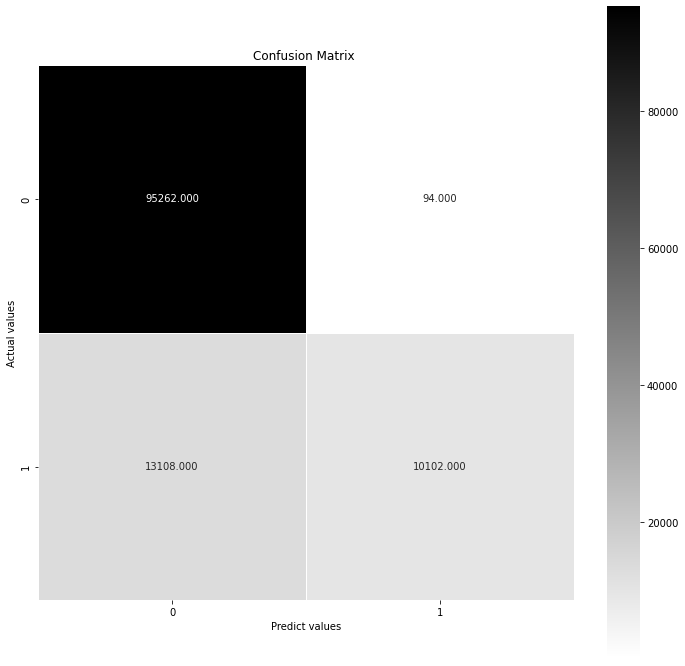


***************************************************************************************************
Decision Tree with Random Over Sampling data
Prediction for test data:
Accuracy Score: 83.28%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     95356
           1       0.57      0.59      0.58     23210

    accuracy                           0.83    118566
   macro avg       0.73      0.74      0.74    118566
weighted avg       0.83      0.83      0.83    118566

_______________________________________________
Confusion Matrix: 
 [[85133 10223]
 [ 9604 13606]]



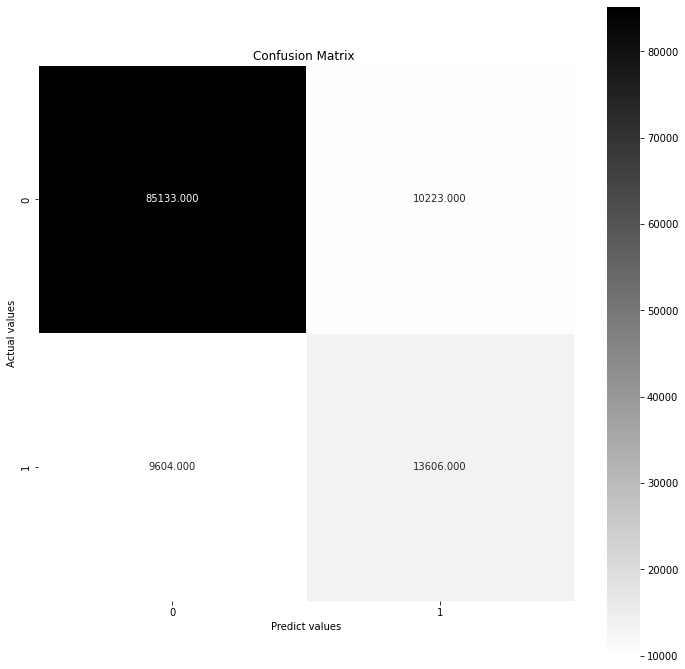


***************************************************************************************************
Naive Bayes with Random Over Sampling data
Prediction for test data:
Accuracy Score: 86.20%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     95356
           1       0.67      0.57      0.62     23210

    accuracy                           0.86    118566
   macro avg       0.79      0.75      0.77    118566
weighted avg       0.86      0.86      0.86    118566

_______________________________________________
Confusion Matrix: 
 [[88938  6418]
 [ 9942 13268]]



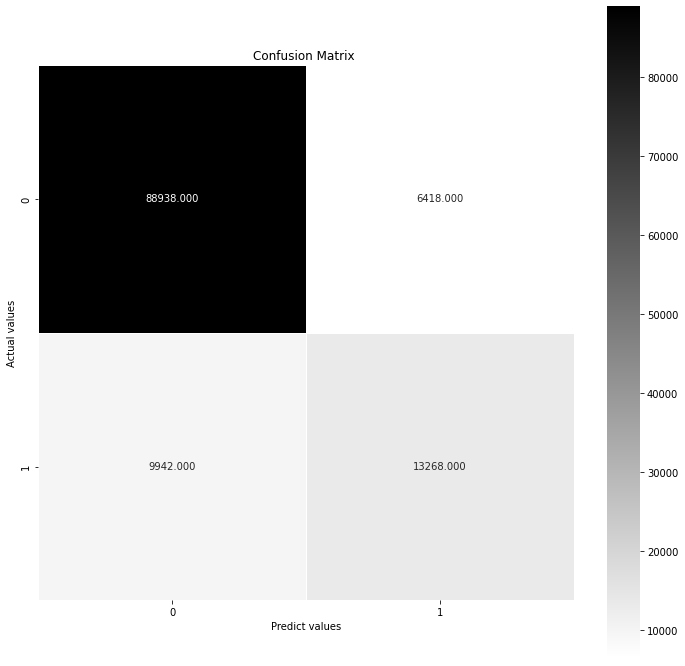


***************************************************************************************************
XGBoost with Random Over Sampling data
Prediction for test data:
Accuracy Score: 81.15%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     95356
           1       0.51      0.79      0.62     23210

    accuracy                           0.81    118566
   macro avg       0.73      0.80      0.75    118566
weighted avg       0.86      0.81      0.83    118566

_______________________________________________
Confusion Matrix: 
 [[77785 17571]
 [ 4780 18430]]



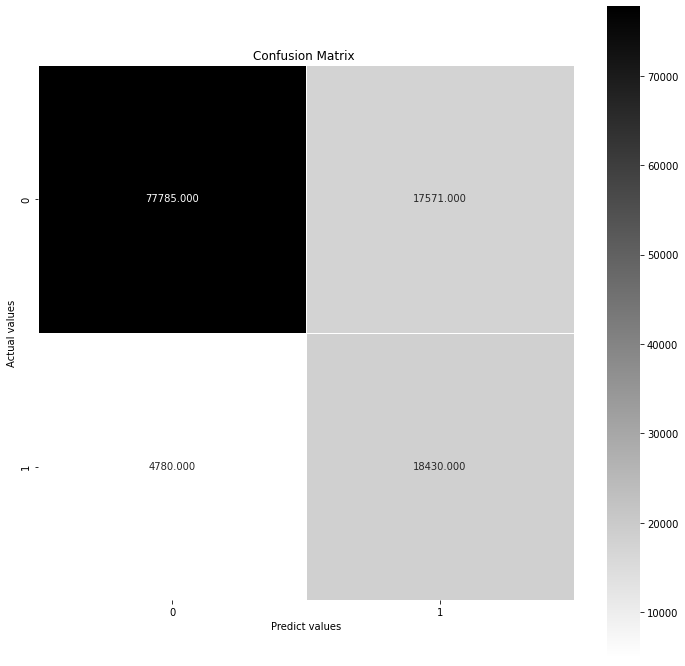


***************************************************************************************************
Random Forest with Random Over Sampling data
Prediction for test data:
Accuracy Score: 88.79%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     95356
           1       0.87      0.50      0.64     23210

    accuracy                           0.89    118566
   macro avg       0.88      0.74      0.79    118566
weighted avg       0.89      0.89      0.88    118566

_______________________________________________
Confusion Matrix: 
 [[93616  1740]
 [11556 11654]]



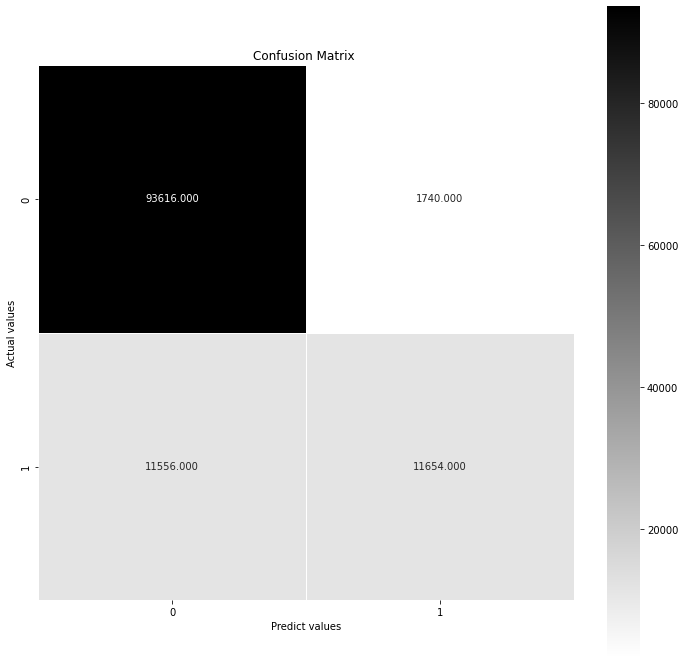


***************************************************************************************************
K Nearest Neighbor with Random Over Sampling data
Prediction for test data:
Accuracy Score: 76.37%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     95356
           1       0.44      0.71      0.54     23210

    accuracy                           0.76    118566
   macro avg       0.68      0.74      0.69    118566
weighted avg       0.82      0.76      0.78    118566

_______________________________________________
Confusion Matrix: 
 [[74092 21264]
 [ 6758 16452]]



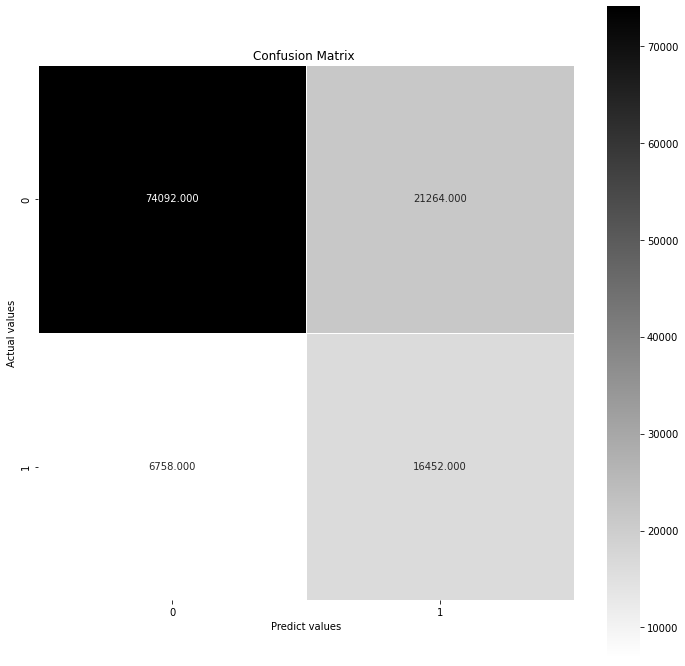


***************************************************************************************************
Gradient Boosting with Random Over Sampling data
Prediction for test data:
Accuracy Score: 80.37%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     95356
           1       0.50      0.79      0.61     23210

    accuracy                           0.80    118566
   macro avg       0.72      0.80      0.74    118566
weighted avg       0.85      0.80      0.82    118566

_______________________________________________
Confusion Matrix: 
 [[76963 18393]
 [ 4885 18325]]



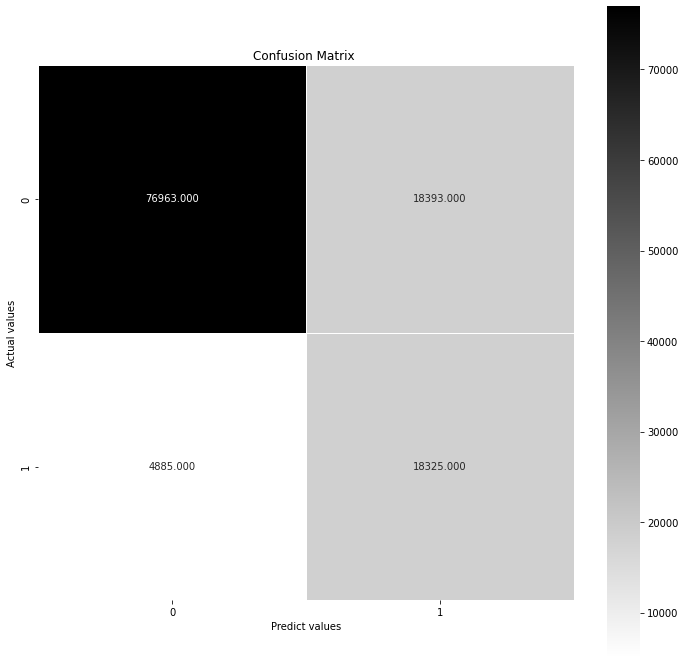


***************************************************************************************************
Decision Tree with Random Under Sampling data
Prediction for test data:
Accuracy Score: 74.59%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83     95356
           1       0.42      0.75      0.54     23210

    accuracy                           0.75    118566
   macro avg       0.67      0.75      0.68    118566
weighted avg       0.82      0.75      0.77    118566

_______________________________________________
Confusion Matrix: 
 [[71083 24273]
 [ 5849 17361]]



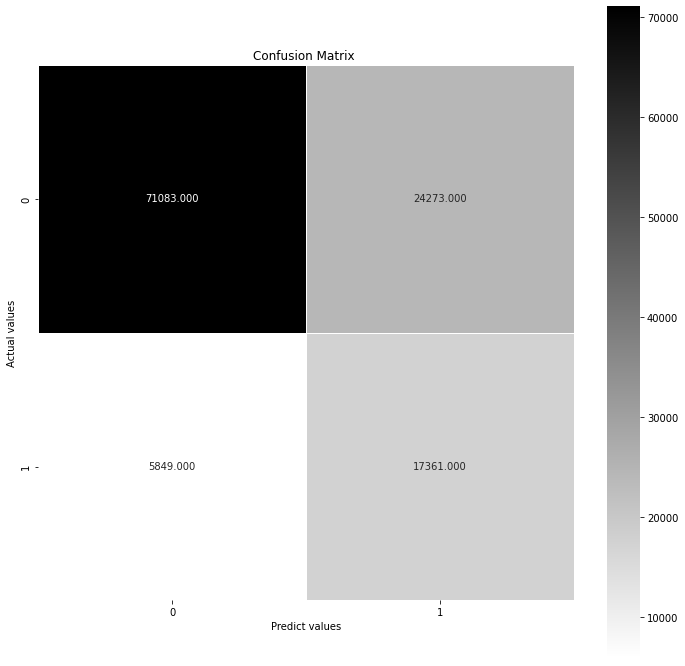


***************************************************************************************************
Naive Bayes with Random Under Sampling data
Prediction for test data:
Accuracy Score: 86.28%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     95356
           1       0.68      0.57      0.62     23210

    accuracy                           0.86    118566
   macro avg       0.79      0.75      0.77    118566
weighted avg       0.86      0.86      0.86    118566

_______________________________________________
Confusion Matrix: 
 [[89072  6284]
 [ 9983 13227]]



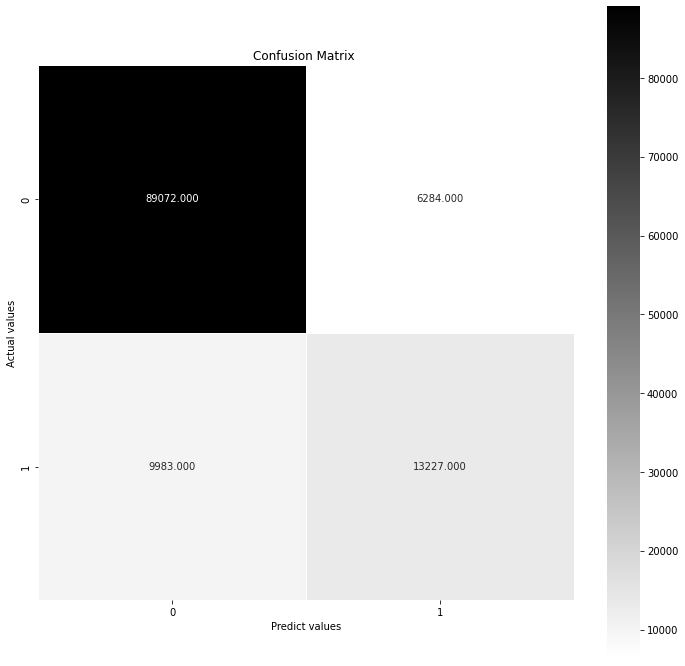


***************************************************************************************************
XGBoost with Random Under Sampling data
Prediction for test data:
Accuracy Score: 79.83%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86     95356
           1       0.49      0.81      0.61     23210

    accuracy                           0.80    118566
   macro avg       0.72      0.80      0.74    118566
weighted avg       0.86      0.80      0.81    118566

_______________________________________________
Confusion Matrix: 
 [[75868 19488]
 [ 4428 18782]]



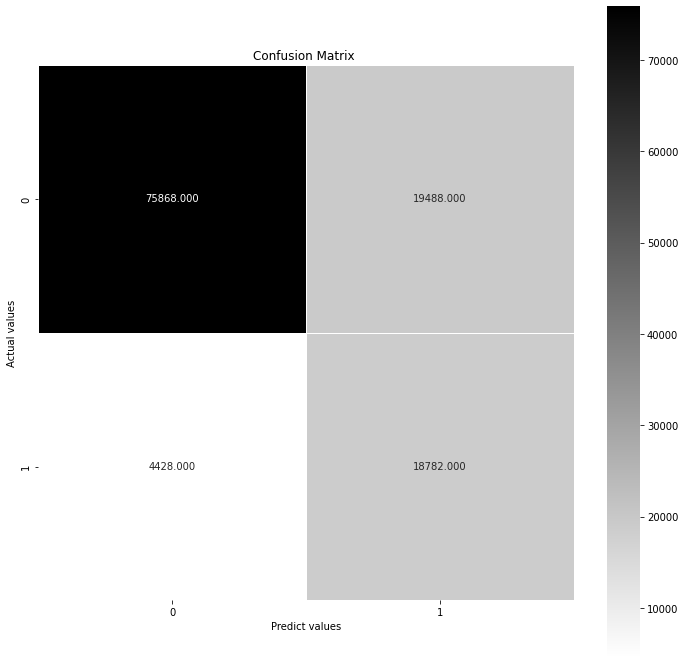


***************************************************************************************************
Random Forest with Random Under Sampling data
Prediction for test data:
Accuracy Score: 80.91%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     95356
           1       0.51      0.77      0.61     23210

    accuracy                           0.81    118566
   macro avg       0.72      0.79      0.74    118566
weighted avg       0.85      0.81      0.82    118566

_______________________________________________
Confusion Matrix: 
 [[78074 17282]
 [ 5354 17856]]



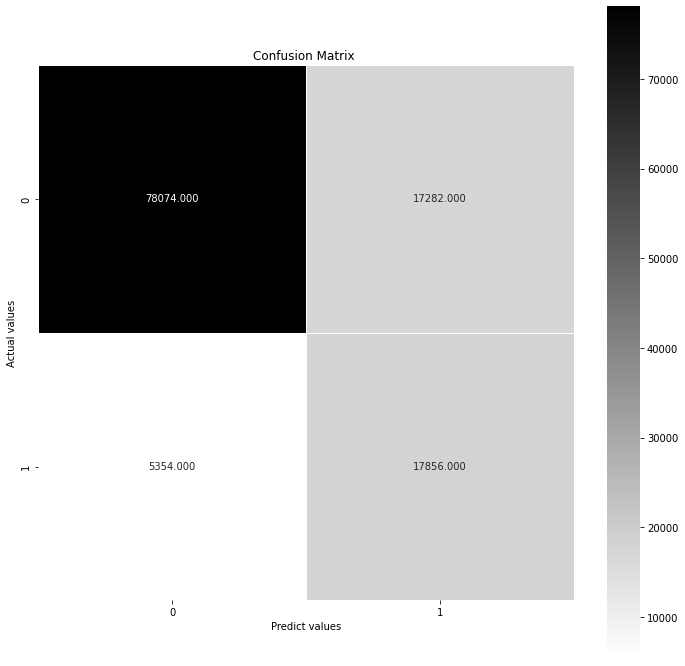


***************************************************************************************************
K Nearest Neighbor with Random Under Sampling data
Prediction for test data:
Accuracy Score: 75.67%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.93      0.76      0.83     95356
           1       0.43      0.75      0.55     23210

    accuracy                           0.76    118566
   macro avg       0.68      0.76      0.69    118566
weighted avg       0.83      0.76      0.78    118566

_______________________________________________
Confusion Matrix: 
 [[72212 23144]
 [ 5708 17502]]



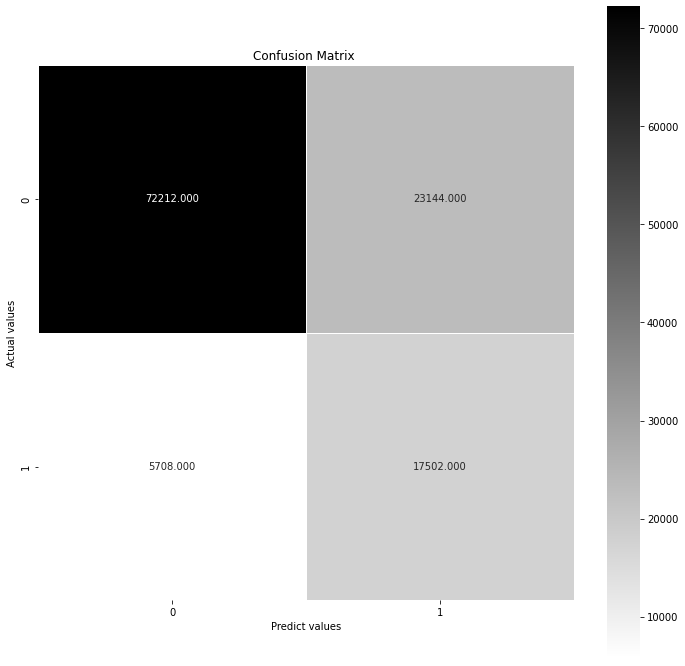


***************************************************************************************************
Gradient Boosting with Random Under Sampling data
Prediction for test data:
Accuracy Score: 80.26%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     95356
           1       0.50      0.79      0.61     23210

    accuracy                           0.80    118566
   macro avg       0.72      0.80      0.74    118566
weighted avg       0.85      0.80      0.82    118566

_______________________________________________
Confusion Matrix: 
 [[76801 18555]
 [ 4854 18356]]



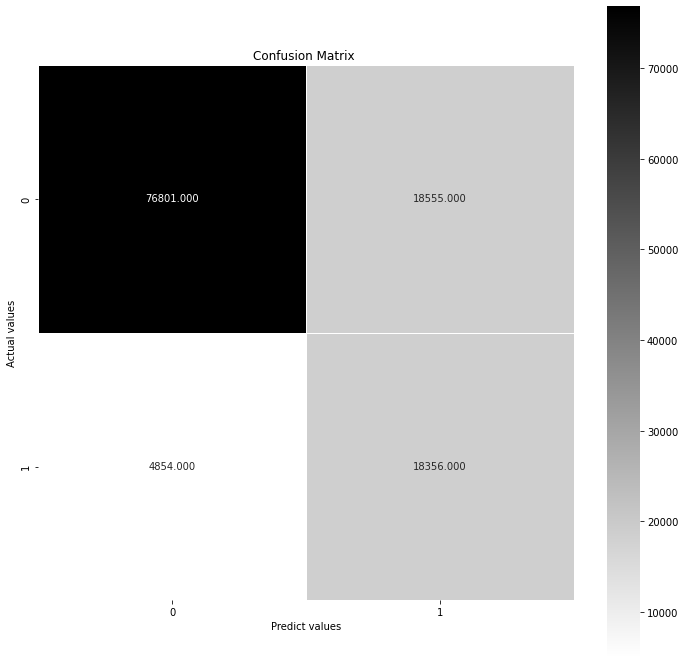


***************************************************************************************************
Decision Tree with SMOTE data
Prediction for test data:
Accuracy Score: 81.51%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88     95356
           1       0.52      0.59      0.56     23210

    accuracy                           0.82    118566
   macro avg       0.71      0.73      0.72    118566
weighted avg       0.82      0.82      0.82    118566

_______________________________________________
Confusion Matrix: 
 [[82860 12496]
 [ 9424 13786]]



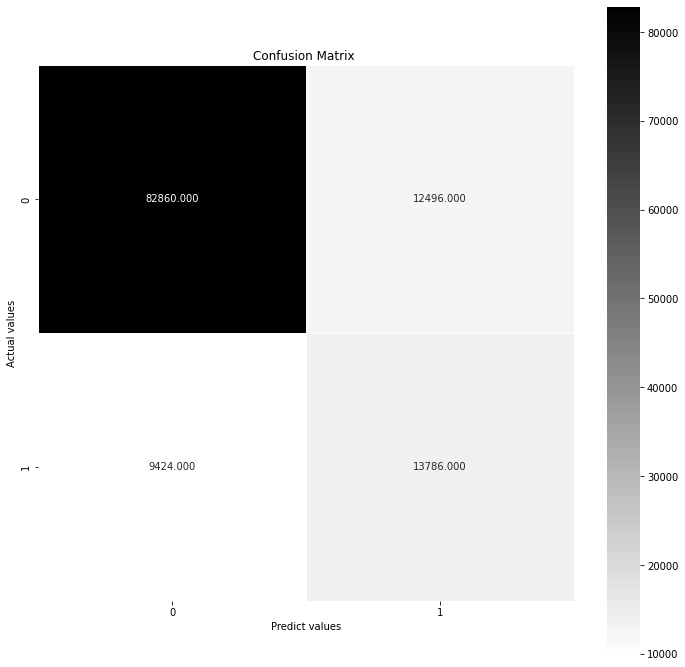


***************************************************************************************************
Naive Bayes with SMOTE data
Prediction for test data:
Accuracy Score: 86.05%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     95356
           1       0.66      0.59      0.62     23210

    accuracy                           0.86    118566
   macro avg       0.78      0.76      0.77    118566
weighted avg       0.86      0.86      0.86    118566

_______________________________________________
Confusion Matrix: 
 [[88428  6928]
 [ 9617 13593]]



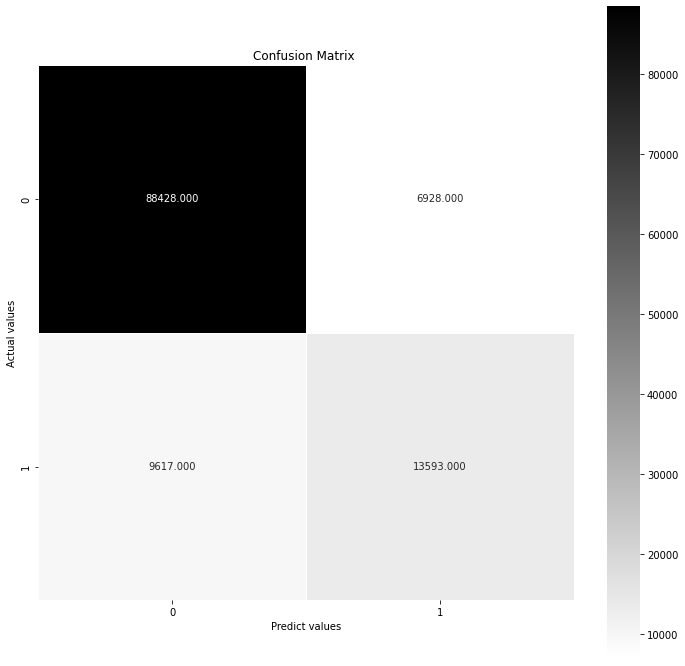


***************************************************************************************************
XGBoost with SMOTE data
Prediction for test data:
Accuracy Score: 88.82%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     95356
           1       0.88      0.50      0.64     23210

    accuracy                           0.89    118566
   macro avg       0.88      0.74      0.79    118566
weighted avg       0.89      0.89      0.88    118566

_______________________________________________
Confusion Matrix: 
 [[93701  1655]
 [11602 11608]]



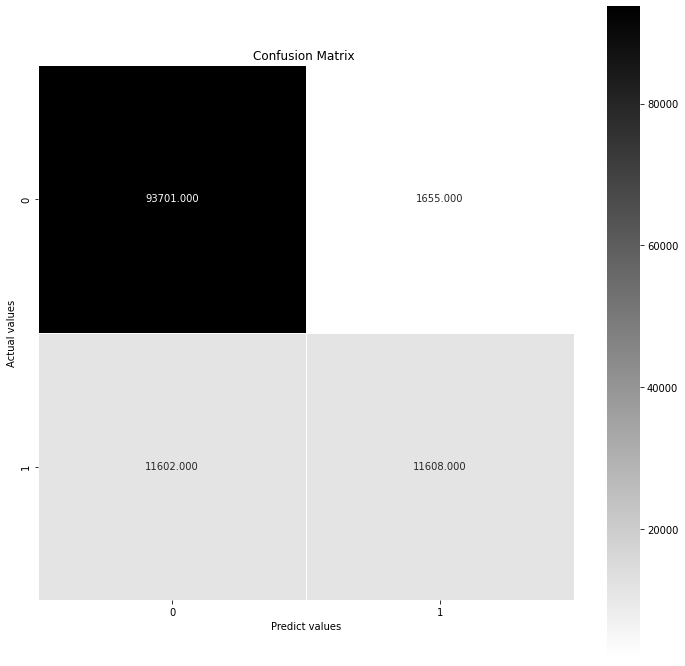


***************************************************************************************************
Random Forest with SMOTE data
Prediction for test data:
Accuracy Score: 87.52%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     95356
           1       0.74      0.56      0.64     23210

    accuracy                           0.88    118566
   macro avg       0.82      0.75      0.78    118566
weighted avg       0.87      0.88      0.87    118566

_______________________________________________
Confusion Matrix: 
 [[90837  4519]
 [10282 12928]]



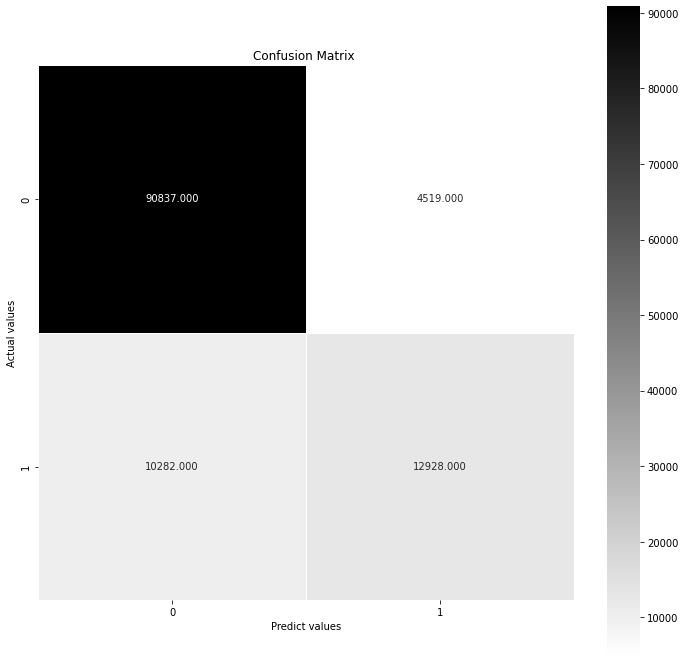


***************************************************************************************************
K Nearest Neighbor with SMOTE data
Prediction for test data:
Accuracy Score: 78.01%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     95356
           1       0.46      0.70      0.55     23210

    accuracy                           0.78    118566
   macro avg       0.69      0.75      0.70    118566
weighted avg       0.83      0.78      0.80    118566

_______________________________________________
Confusion Matrix: 
 [[76289 19067]
 [ 7004 16206]]



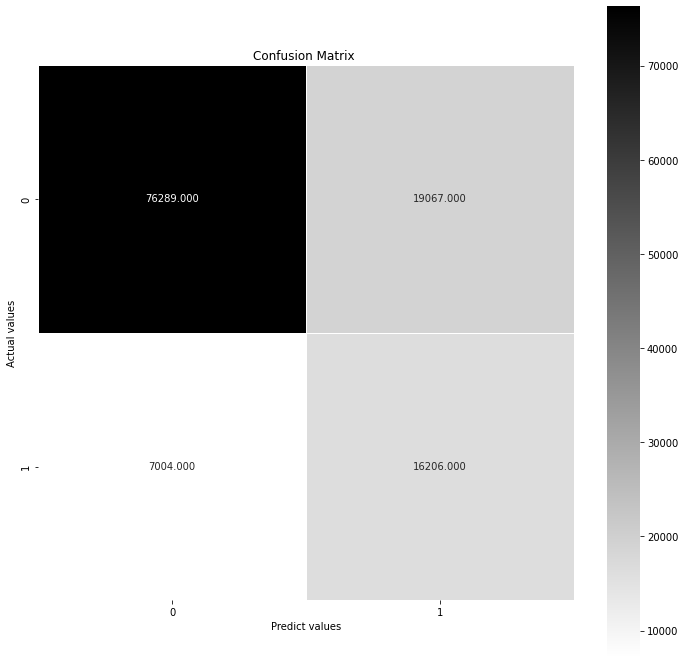


***************************************************************************************************
Gradient Boosting with SMOTE data
Prediction for test data:
Accuracy Score: 84.86%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     95356
           1       0.60      0.66      0.63     23210

    accuracy                           0.85    118566
   macro avg       0.76      0.78      0.77    118566
weighted avg       0.85      0.85      0.85    118566

_______________________________________________
Confusion Matrix: 
 [[85311 10045]
 [ 7911 15299]]



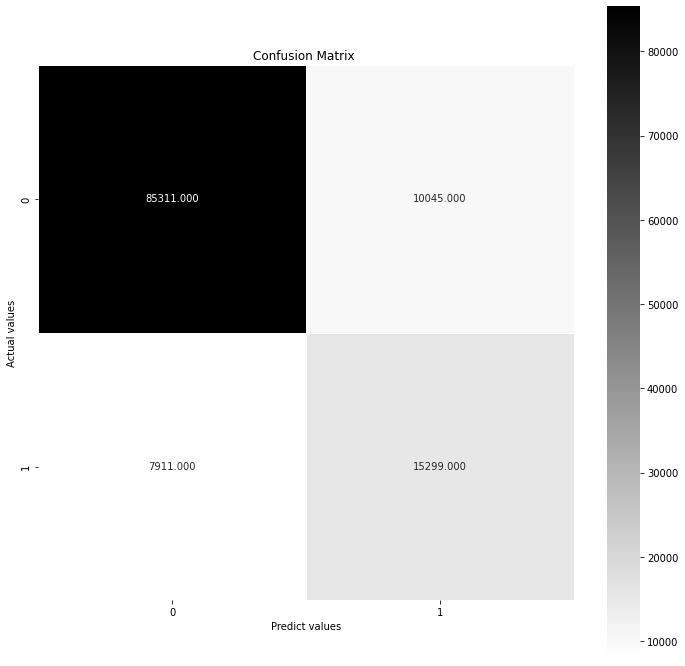


***************************************************************************************************
Decision Tree with Near Miss data
Prediction for test data:
Accuracy Score: 53.23%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.48      0.62     95356
           1       0.26      0.76      0.39     23210

    accuracy                           0.53    118566
   macro avg       0.58      0.62      0.51    118566
weighted avg       0.77      0.53      0.58    118566

_______________________________________________
Confusion Matrix: 
 [[45461 49895]
 [ 5557 17653]]



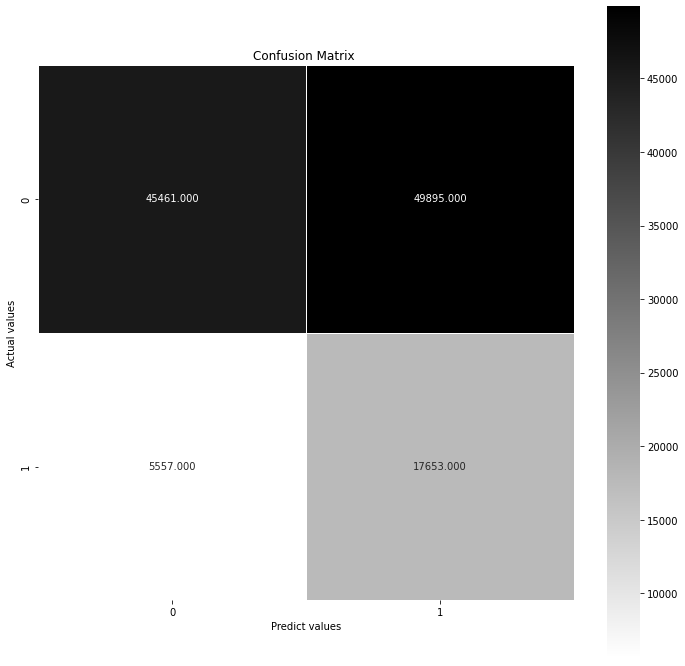


***************************************************************************************************
Naive Bayes with Near Miss data
Prediction for test data:
Accuracy Score: 80.88%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     95356
           1       0.51      0.51      0.51     23210

    accuracy                           0.81    118566
   macro avg       0.70      0.70      0.70    118566
weighted avg       0.81      0.81      0.81    118566

_______________________________________________
Confusion Matrix: 
 [[83979 11377]
 [11289 11921]]



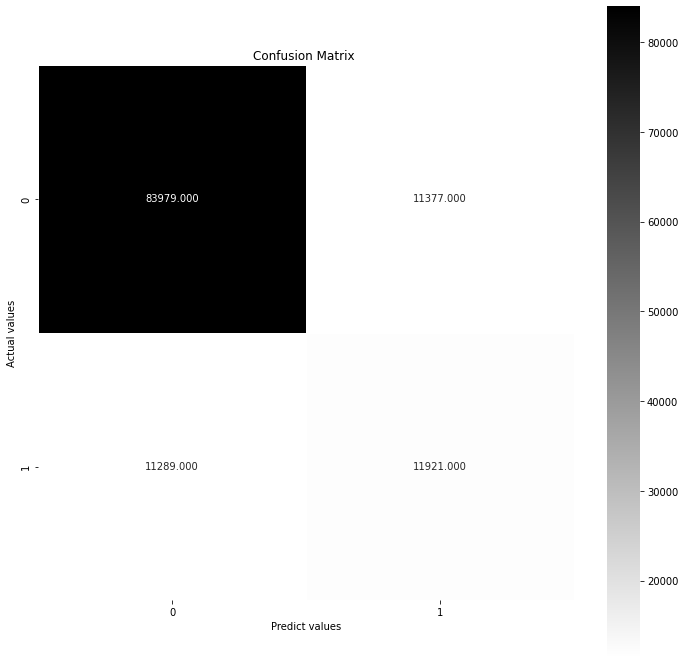


***************************************************************************************************
XGBoost with Near Miss data
Prediction for test data:
Accuracy Score: 58.93%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.55      0.68     95356
           1       0.29      0.74      0.41     23210

    accuracy                           0.59    118566
   macro avg       0.59      0.64      0.55    118566
weighted avg       0.78      0.59      0.63    118566

_______________________________________________
Confusion Matrix: 
 [[52790 42566]
 [ 6132 17078]]



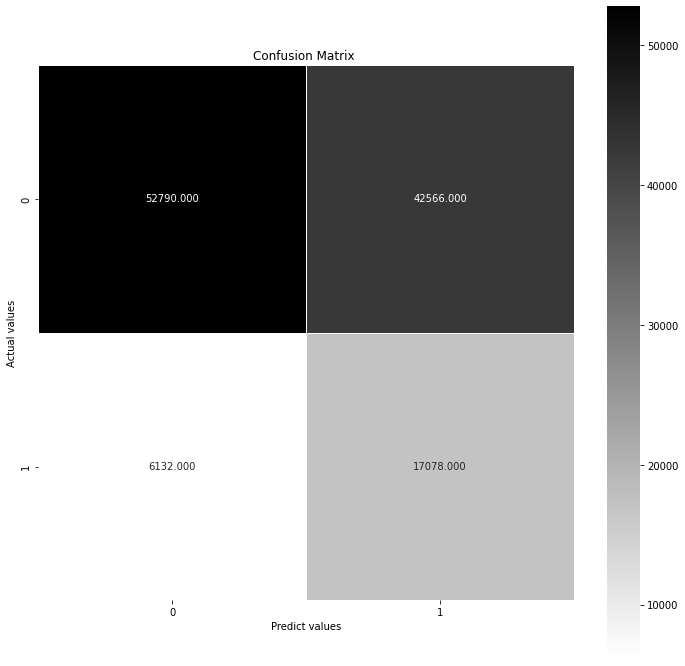


***************************************************************************************************
Random Forest with Near Miss data
Prediction for test data:
Accuracy Score: 54.51%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.50      0.64     95356
           1       0.26      0.74      0.39     23210

    accuracy                           0.55    118566
   macro avg       0.58      0.62      0.51    118566
weighted avg       0.76      0.55      0.59    118566

_______________________________________________
Confusion Matrix: 
 [[47505 47851]
 [ 6082 17128]]



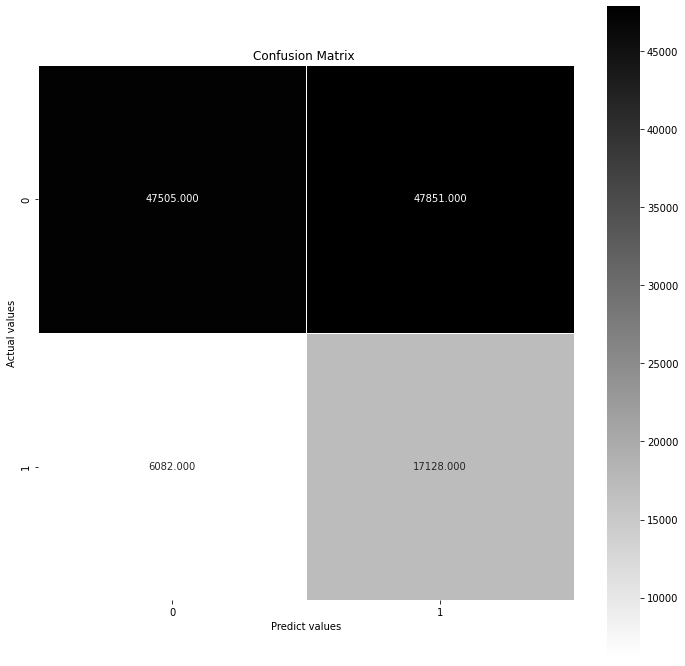


***************************************************************************************************
K Nearest Neighbor with Near Miss data
Prediction for test data:
Accuracy Score: 56.19%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.53      0.66     95356
           1       0.27      0.70      0.39     23210

    accuracy                           0.56    118566
   macro avg       0.57      0.61      0.52    118566
weighted avg       0.76      0.56      0.61    118566

_______________________________________________
Confusion Matrix: 
 [[50338 45018]
 [ 6930 16280]]



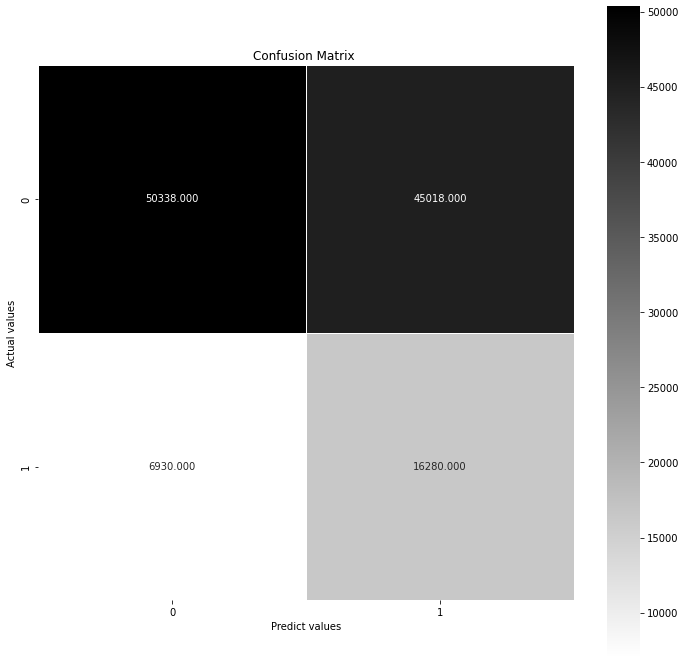


***************************************************************************************************
Gradient Boosting with Near Miss data
Prediction for test data:
Accuracy Score: 62.87%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.61      0.73     95356
           1       0.31      0.71      0.43     23210

    accuracy                           0.63    118566
   macro avg       0.60      0.66      0.58    118566
weighted avg       0.78      0.63      0.67    118566

_______________________________________________
Confusion Matrix: 
 [[58179 37177]
 [ 6846 16364]]



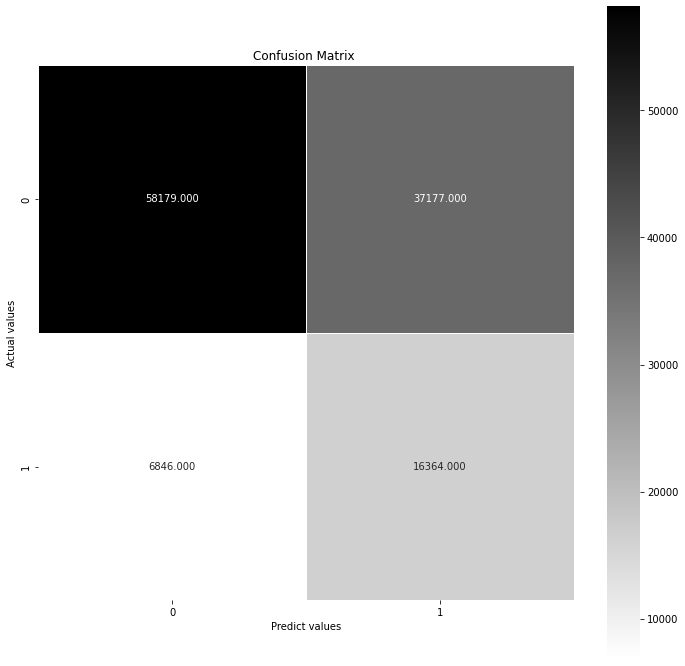

In [ ]:
for trainset in train_data:
    x_set = train_data[trainset][0]
    y_set = train_data[trainset][1]


    lr = LogisticRegression(solver='liblinear')
    nb = GaussianNB()
    svm = SVC()
    tree = DecisionTreeClassifier(criterion='gini')
    xgboost = xgb.XGBClassifier(objective='binary:logistic')
    knn = KNeighborsClassifier()
    gdboost = GradientBoostingClassifier()
    rf = RandomForestClassifier()
    algos = {'Decision Tree': tree, 
    'Naive Bayes': nb, 
    'XGBoost': xgboost, 
    'Random Forest': rf, 
    "K Nearest Neighbor": knn, 
    'Gradient Boosting': gdboost}

    for algo in algos:
        print("\n***************************************************************************************************")
        fit_model_and_evaluate(algos[algo], algo + " with " + trainset + " data", x_set, y_set)


XGBoost: f1=0.622 auc=0.780


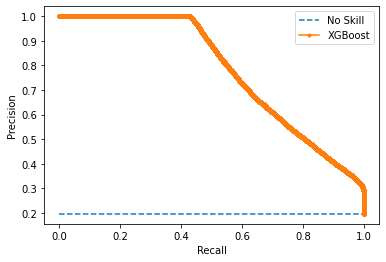

In [55]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# fit a model
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(rd_over_x_train, rd_over_y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('XGBoost: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Prediction for train data:
Accuracy Score: 81.04%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     95356
           1       0.51      0.80      0.62     23210

    accuracy                           0.81    118566
   macro avg       0.73      0.80      0.75    118566
weighted avg       0.86      0.81      0.82    118566

_______________________________________________
Confusion Matrix: 
 [[77620 17736]
 [ 4742 18468]]



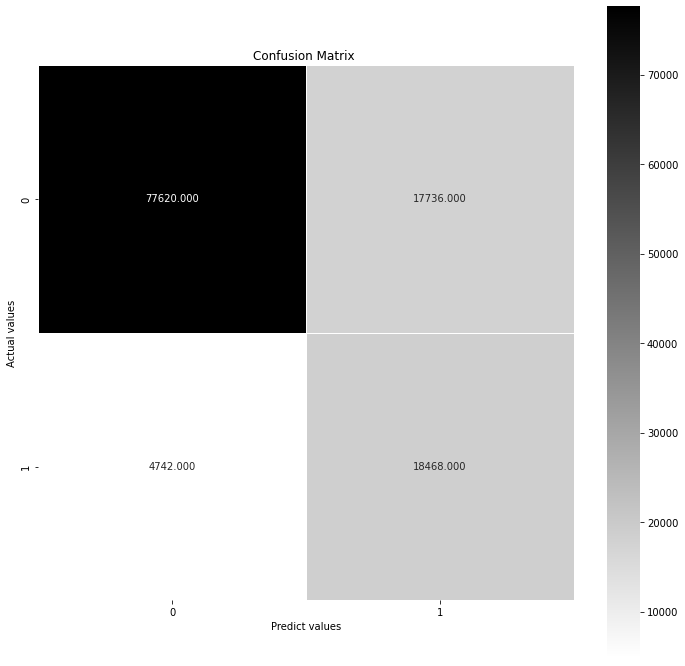

In [57]:
print_score(y_test, yhat)

In [58]:
pickle.dump(model, open('xgboost2.pkl', 'wb'))

In [117]:
X_train.shape

(276653, 82)